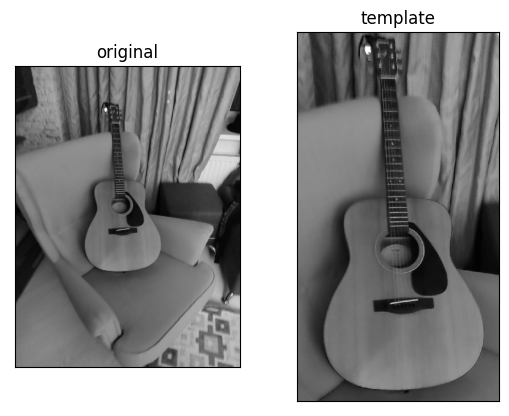

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

template = cv2.imread('data/img1.1.jpg',cv2.IMREAD_GRAYSCALE)# Эталон
image = cv2.imread('data/img1.jpg',cv2.IMREAD_GRAYSCALE) # Сцена с эталоном

titles = ["original", "template"]
images = [image,template]
for i in range(2):
    plt.subplot(1,2,i+1),plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

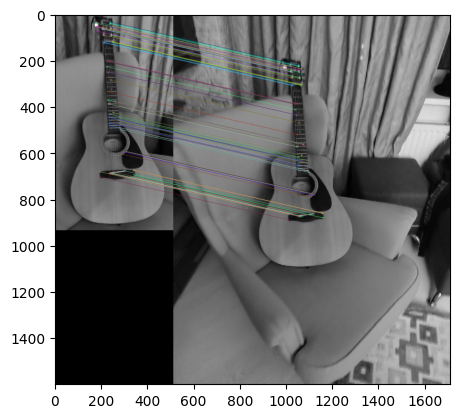

(<matplotlib.image.AxesImage at 0x1dc84731310>, None)

In [22]:
# Инициализируем ORB
orb = cv2.ORB_create()

# Находим ключевые точки и дескрипторы с помощью ORB
kp_template, des_template = orb.detectAndCompute(template,None)
kp_image, des_image = orb.detectAndCompute(image,None)

# Инициализируем BFMatcher 
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Находим соответсвия между дескрипторами
matches = bf.match(des_template,des_image)

# Сортируем соответсвия по дистанции от меньшей к большей
matches = sorted(matches, key = lambda x:x.distance)

# Рисуем первые 100 соответсвий.
result = cv2.drawMatches(template,kp_template,image,kp_image,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(result),plt.show()

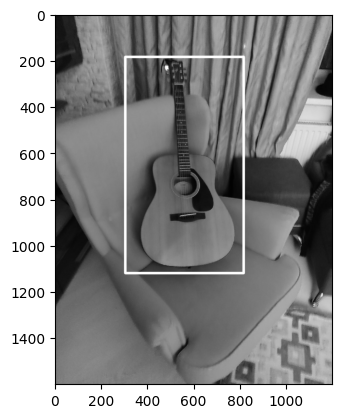

In [23]:
#Записываем первые 10 соответсвий с эталона и исходного изображения
src_pts = np.float32([ kp_template[m.queryIdx].pt for m in matches[:10] ]).reshape(-1,1,2)
dst_pts = np.float32([ kp_image[m.trainIdx].pt for m in matches[:10] ]).reshape(-1,1,2)

# Рассчитываем матрицу гомографии
h, _ = cv2.findHomography(src_pts, dst_pts)

# Трансформируем исходное изображение, используя полученную гомографию
#im_out = cv2.warpPerspective(template, h, (image.shape[1],image.shape[0]))


rectangle_pts = np.float32([[0, 0], 
                            [0,template.shape[0]],
                            [template.shape[1],0],
                            [template.shape[1],template.shape[0]]]).reshape(-1,1,2)

rectangle_pts = cv2.perspectiveTransform(rectangle_pts,h).reshape(-1,2)

#Находим углы рамки
left_top = [image.shape[1],image.shape[0]]
right_bottom = [0,0]

for point in  rectangle_pts:
    #Находим левую верхнюю точку рамки
    if point[0] < left_top[0]:
        left_top[0] = point[0] if point[0] >= 0 else 0
    if point[1] < left_top[1]:
        left_top[1] = point[1] if point[1] >= 0 else 0
        
    #Находим правую нижнюю точку рамки
    if point[0] > right_bottom[0]:
        right_bottom[0] = point[0] if point[0] <= image.shape[1] else image.shape[1]
    if point[1] > right_bottom[1]:
        right_bottom[1] = point[1] if point[1] <= image.shape[0] else image.shape[0]
        
#Чтобы рамку было видно у края изображения:
left_top = [int(left_top[0]),int(left_top[1])]
if left_top[0] == 0:
    left_top[0] += 10
if left_top[1] == 0:
    left_top[1] += 10
    
right_bottom = [int(right_bottom[0]),int(right_bottom[1])]
if right_bottom[0] == image.shape[1]:
    right_bottom[0] -= 10
if right_bottom[1] == image.shape[0]:
    right_bottom[1] -= 10
    
    
#Чертим рамку
result = image.copy()
cv2.rectangle(result, left_top, right_bottom, 255, 10) 

#Вывод mathplotlib
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()